## Python version required: 3.7

In [1]:
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import itertools as itr

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Data/household_power_consumption.txt', sep=";")
test_data = data.head(200)
data.head()
len(data)

2075259

In [3]:
parse_dates = test_data['Date'] + ' ' + test_data['Time']
power = test_data['Global_active_power']

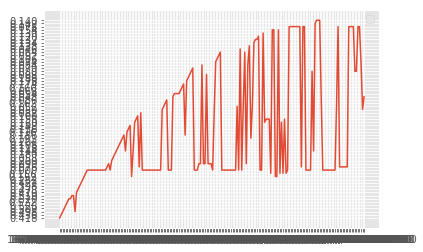

In [4]:
plt.plot(parse_dates,test_data['Global_reactive_power'], label = 'usage')
plt.legend('')
plt.show()

## Get the average usage per day
Since data is quite large, we would to first see the average usage per day. Before we can do that, we have to combine Data with Time so we can create a proper datetime type for the table.

In [5]:
type(data['Date'][1])


str

In [6]:
data_datetime = data['Date'] + ' ' + data['Time']
data['Date'] = data_datetime
del data['Time']
data.head()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
data['Date'] = data_datetime = pd.to_datetime(data['Date'])
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce').fillna(0)
data.head()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
type(data['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
type(data['Global_active_power'][1])

numpy.float64

## Grab date from datetime + needed column

In [10]:
NeededColumns = data[['Date', 'Global_active_power']]

NeededColumns= NeededColumns.resample('h', on='Date').sum()
NeededColumnsv2= NeededColumns
NeededColumns.head()

# Devide by 60

,Global_active_power
Date,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


In [11]:
type(NeededColumns['Global_active_power'][1])

numpy.float64

In [12]:
for i in range(len(NeededColumns)):
    number = NeededColumns['Global_active_power'][i]
    NeededColumns['Global_active_power'][i] = number
    
NeededColumns.head()

,Global_active_power
Date,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


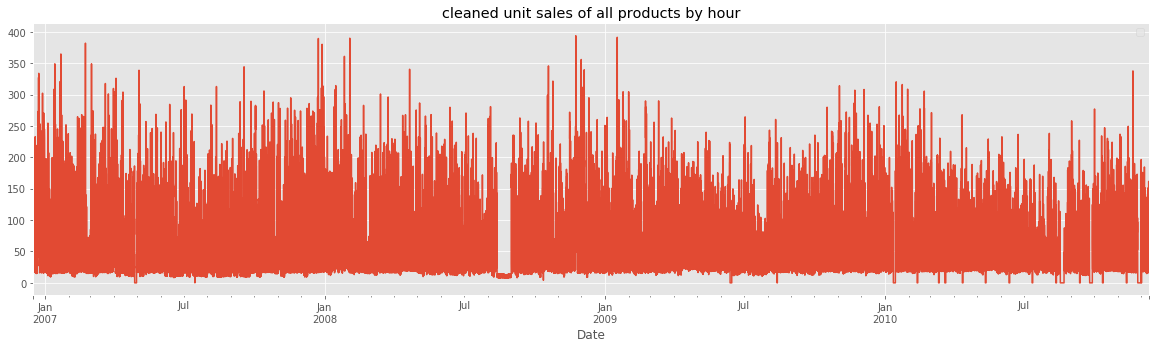

In [13]:
test = NeededColumns['Global_active_power']
test.plot(figsize=(20, 5),
          title='cleaned unit sales of all products by hour')
plt.legend('')
plt.show()

## Selecting seasonalities

In [14]:
test.head()

Date
2006-12-16 17:00:00    152.024
2006-12-16 18:00:00    217.932
2006-12-16 19:00:00    204.014
2006-12-16 20:00:00    196.114
2006-12-16 21:00:00    183.388
Freq: H, Name: Global_active_power, dtype: float64

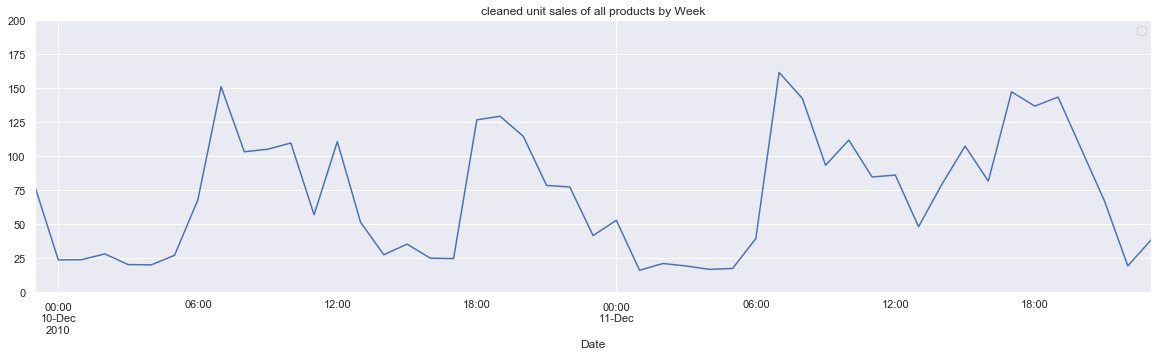

In [33]:
y_week = test.reset_index()
y_week['Date'] = pd.to_datetime(y_week['Date'])
y_week = y_week.set_index('Date')
y_week['Date'] = y_week.resample('W').sum()

y_week.iloc[-49:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by Week')
plt.legend('')
plt.ylim([0.0,200])
plt.show()

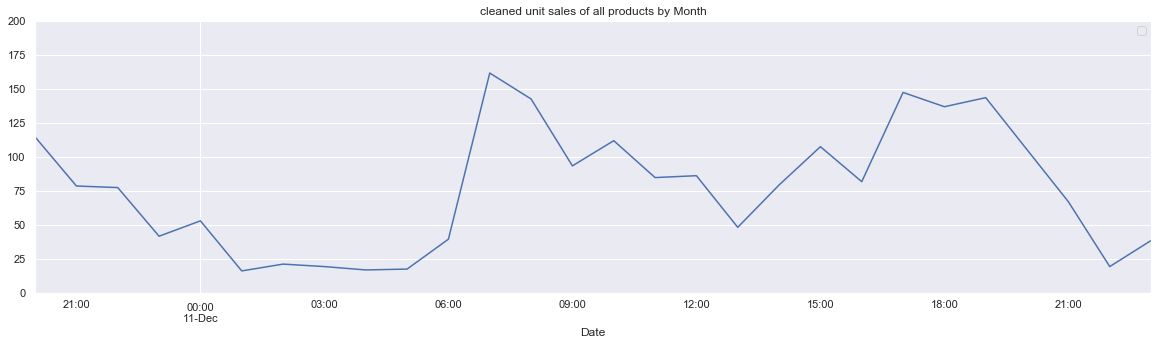

In [34]:
y_month = test.reset_index()
y_month['Date'] = pd.to_datetime(y_month['Date'])
y_month = y_month.set_index('Date')
y_month['Date'] = y_month.resample('M').sum()

y_month.iloc[-28:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by Month')
plt.legend('')
plt.ylim([0.0,200])
plt.show()

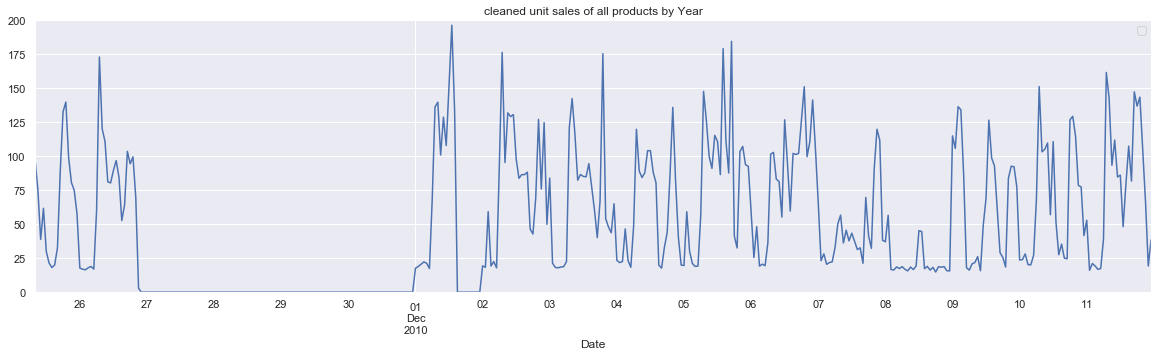

In [35]:
y_year = test.reset_index()
y_year['Date'] = pd.to_datetime(y_year['Date'])
y_year = y_year.set_index('Date')
y_year['Date'] = y_year.resample('Y').sum()

y_year.iloc[-400:,].plot(figsize=(20, 5),
          title='cleaned unit sales of all products by Year')
plt.legend('')
plt.ylim([0.0,200.0])
plt.show()

Removing trend and seasonalities¶
Starting from an additive model hypothesis [1], the idea is fitting a linear regression model over the fourier series corresponding to the different seasonalities that we have [2].

Indeed, we will be able to extract the trend and the seasonality components leaving only the noise to predict with the SARIMAX model, see the formulas below:

ysales=Constant+Trend+Seasonality+Noise   [1]
 
ysales=b0+b1t+b2cos(2πt365)+b3sin(2πt365)+b4cos(2πt30)+b5sin(2πt30)+b6cos(2πt7)+b7sin(2πt7)+ϵ   [2]
The performance of the linear regression model will be evaluated using the coefficient of determination, denoted as R². it tells us which amount of variation in y_sales can be explained by the dependence on the periodic functions we used as regressors.

In [18]:
y_sales = test.reset_index().drop(['Date'], axis=1)


#Time scale
predic1 = range(len(y_sales))

#Applying the Fourier series to the time scale
predic_annual_cos = list(map(lambda x: math.cos(2*math.pi*x/8760), predic1))
predic_annual_sin = list(map(lambda x: math.sin(2*math.pi*x/8760), predic1))

predic_month_cos = list(map(lambda x: math.cos(2*math.pi*x/720), predic1))
predic_month_sin = list(map(lambda x: math.sin(2*math.pi*x/720), predic1))

predic_week_cos = list(map(lambda x: math.cos(2*math.pi*x/24), predic1))
predic_week_sin = list(map(lambda x: math.sin(2*math.pi*x/24), predic1))

#assembling the regressors
reg = pd.DataFrame(list(zip(predic1, predic_annual_cos, predic_annual_sin, predic_month_cos, predic_month_sin, predic_week_cos, predic_week_sin)), 
               columns =['predic1', 'predic_annual_cos', 'predic_annual_sin', 'predic_month_cos', 'predic_month_sin', 'predic_week_cos', 'predic_week_sin']) 

#Model
model = LinearRegression().fit(reg, y_sales)

#The estimated parameters
r2 = model.score(reg, y_sales)
print('coefficient of determination:', r2)

coefficient of determination: 0.09336720146551826


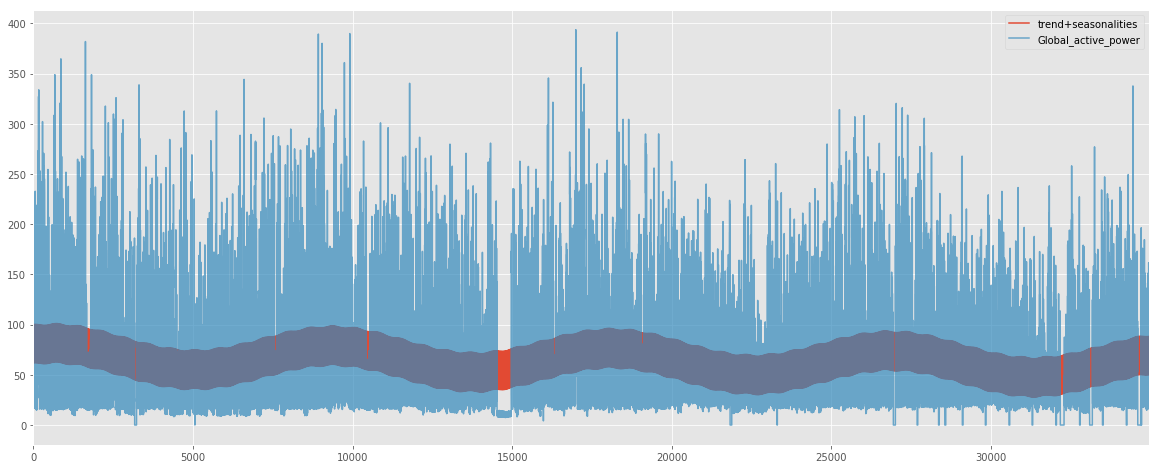

In [19]:
trend = model.intercept_ + model.coef_[0][0]*np.array(predic1)
seas_annual = model.coef_[0][1]*np.array(predic_annual_cos) + model.coef_[0][2]*np.array(predic_annual_sin)
seas_month = model.coef_[0][3]*np.array(predic_month_cos) + model.coef_[0][4]*np.array(predic_month_sin)
seas_week = model.coef_[0][5]*np.array(predic_week_cos) + model.coef_[0][6]*np.array(predic_week_sin)

trend_seas = trend + seas_annual + seas_month + seas_week

ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
y_sales.plot(ax=ax,alpha=0.7)

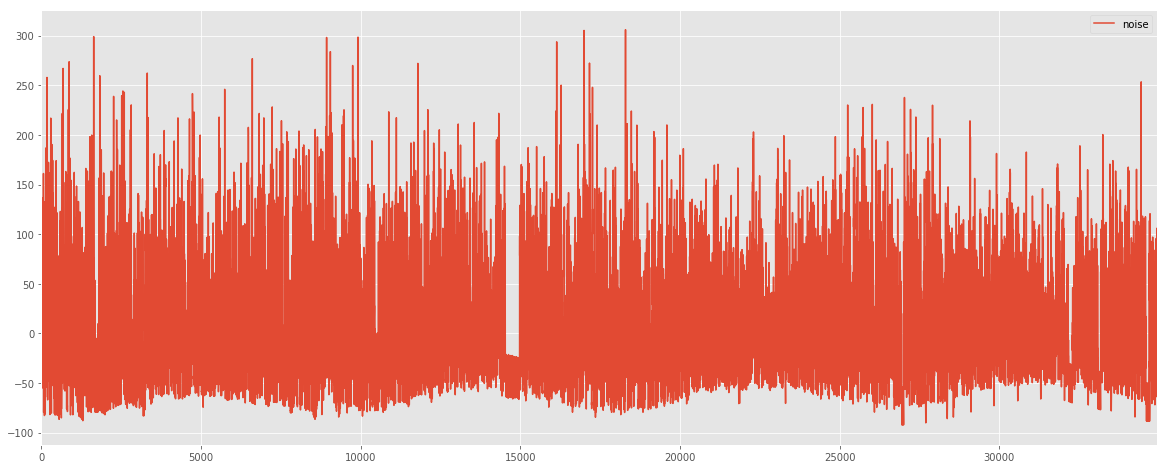

In [20]:
y_adjusted = np.array(list(y_sales['Global_active_power'])) - trend_seas
y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
y_adjusted.plot(figsize=(20,8))

# Training and test datasets

In [21]:
y_train = y_adjusted.iloc[:-28,]
y_test = y_adjusted.iloc[-28:,]

# SARIMAX model
The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time series data that may contain trend and seasonal components. This model has hyperparameters that control the nature of the model performed for the series:

- order: A tuple p, d, and q parameters for the modeling of the trend
- seasonal order: A tuple of P, D, Q, and s parameters for the modeling of the seasonality

p, d and q stand for the number of times or steps to consider for the Autoregressive, the differenciation and the moving average operators, although s is the period of the seasonality we want to include.

## Tuning the model
In our case, since we have already excluded the trend and the seasonalities, the parameter P, D, Q and s will be set to zero (I could have used an ARIMA model, I'm just used to the SARIMAX one).

In order to decide of the adequate values of the remaining hyperparameters, a grid search is done with the following code (The selection criterion is the Akaike information criterion (AIC)):

In [22]:
# Define the p and q parameters to take any value between 0 and 4, d between 0 and 1
p = q = range(0, 6)
d = [0,1,2]

# Generate all different combinations of p, q and q triplets
pdq = list(itr.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [[0,0,0,0]]

warnings.filterwarnings("ignore") # specify to ignore warning messages
minimum = 500000 #initialize the minimum AIC variable with a high enough value
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()
            
            if results.aic < minimum:
                minimum = results.aic
                param_ideal = param
                

            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            
        except:
            print('none')
            continue
            
print('And the result is ARIMA{} - AIC:{}'.format(param_ideal, minimum))

ARIMA(0, 0, 0) - AIC:374456.71927506034
ARIMA(0, 0, 1) - AIC:357946.6612930756
ARIMA(0, 0, 2) - AIC:353766.99205833767
ARIMA(0, 0, 3) - AIC:352202.3975839307
ARIMA(0, 0, 4) - AIC:351759.80091671814
ARIMA(0, 0, 5) - AIC:351677.6069079646
ARIMA(0, 1, 0) - AIC:357863.4020253677
ARIMA(0, 1, 1) - AIC:357545.2615877831
ARIMA(0, 1, 2) - AIC:355585.56935656886
ARIMA(0, 1, 3) - AIC:352774.4979753283
ARIMA(0, 1, 4) - AIC:351710.68379074975
ARIMA(0, 1, 5) - AIC:351459.8735360317
ARIMA(0, 2, 0) - AIC:384758.4790014333
ARIMA(0, 2, 1) - AIC:357874.56702908006
ARIMA(0, 2, 2) - AIC:357549.4592537931
ARIMA(0, 2, 3) - AIC:355597.1629892677
ARIMA(0, 2, 4) - AIC:352792.14040400996
ARIMA(0, 2, 5) - AIC:351724.660658081
ARIMA(1, 0, 0) - AIC:351974.08722068486
ARIMA(1, 0, 1) - AIC:351715.5148844653
ARIMA(1, 0, 2) - AIC:351701.8373945673
ARIMA(1, 0, 3) - AIC:351646.2605047971
ARIMA(1, 0, 4) - AIC:351507.31858170626
ARIMA(1, 0, 5) - AIC:351641.0909774691
ARIMA(1, 1, 0) - AIC:357638.9618382314
ARIMA(1, 1, 1) - 

## Evaluating the model
Now that we have set all the model's hyperparameters, let's evaluate its performance.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3105      0.009    265.205      0.000       2.293       2.328
ar.L2         -1.0112      0.022    -45.833      0.000      -1.054      -0.968
ar.L3         -1.7065      0.026    -66.814      0.000      -1.757      -1.656
ar.L4          1.9767      0.020     97.813      0.000       1.937       2.016
ar.L5         -0.5695      0.008    -71.620      0.000      -0.585      -0.554
ma.L1         -1.6378      0.010   -168.116      0.000      -1.657      -1.619
ma.L2         -0.1345      0.020     -6.583      0.000      -0.175      -0.094
ma.L3          1.6916      0.017    101.591      0.000       1.659       1.724
ma.L4         -0.8368      0.015    -54.797      0.000      -0.867      -0.807
ma.L5         -0.0747      0.008     -9.834      0.000      -0.090      -0.060
sigma2      1369.8211      6.913    198.138      0.0

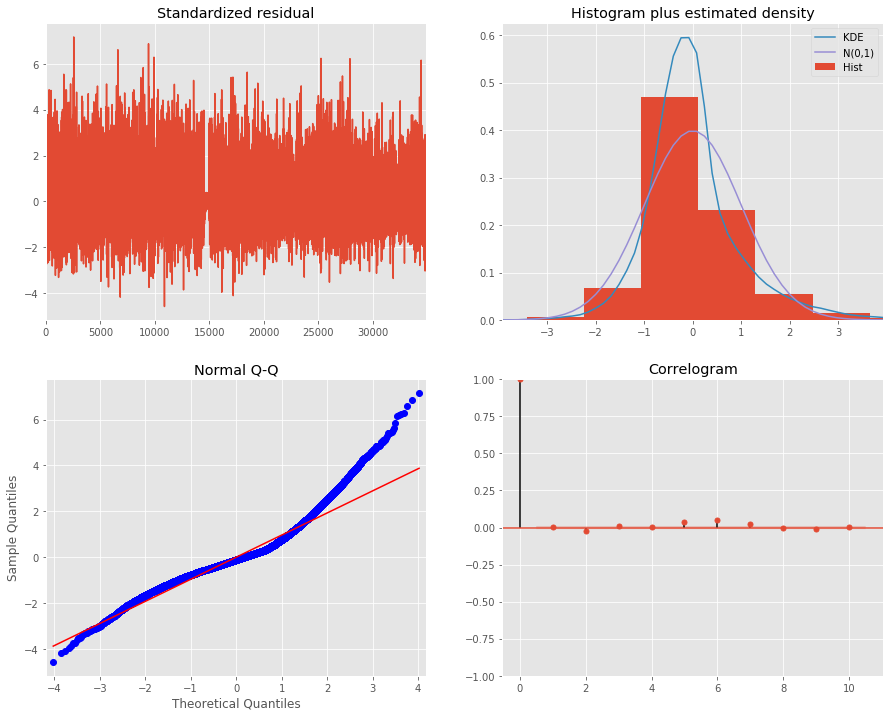

In [23]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(5,0,5),
                                seasonal_order=(0, 0, 0, 0))
results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

The standardized residuals are the error between the model's predictions and the actual observed values, two criterion need to be verified for the adequacy of our SARIMAX model:

- The residuals should follow a Gaussian distribution centered on zero (which is almost the case from the Histogram plus estimated density plot and the Q-Q plot of theoretical quantiles)
- There should be no correlations between the residuals which would mean that there is still significant information to use in computing forecasts (which is verified from the correlogram)

## Testing the model

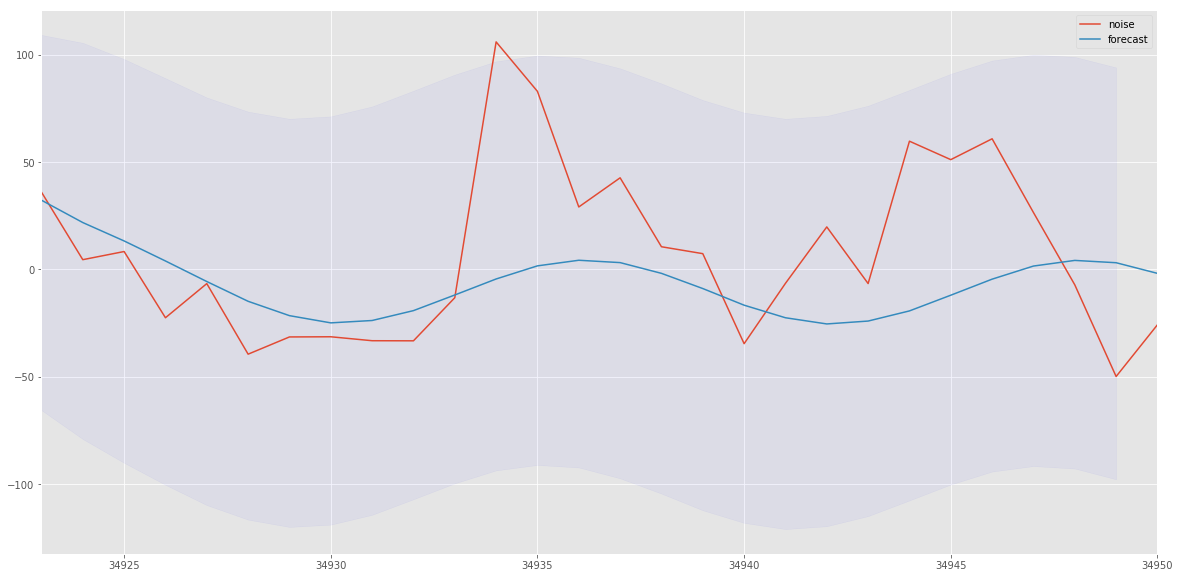

In [24]:
pred = results.get_forecast(steps=28)

ax = y_test.plot(figsize=(20, 10))

pd.DataFrame(pred.predicted_mean, columns=['forecast']).plot(ax=ax)

ax.fill_between(range(34922,34950), pred.conf_int()['lower noise'], pred.conf_int()['upper noise'], color='b', alpha=.04)

plt.legend()
plt.show()

Let's visualize the real forecasts now addind the trend and the seasonality we have extracted.

<function matplotlib.pyplot.show(*args, **kw)>

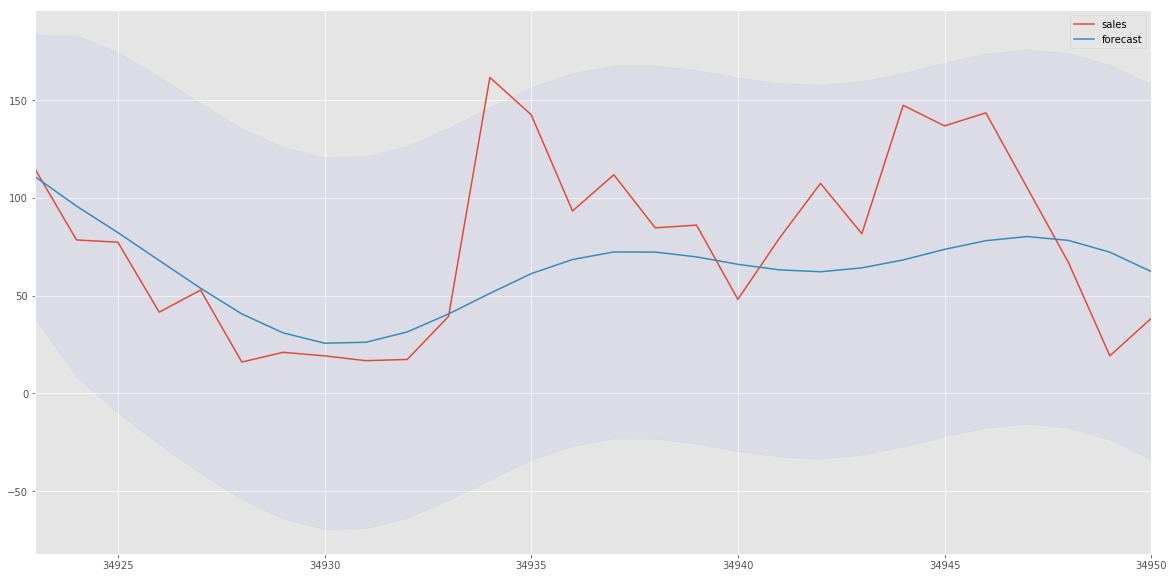

In [25]:
ax = pd.DataFrame(np.array(list(y_test['noise']))+trend_seas[34923:],index = range(34923,34951), columns=['sales']).plot(figsize=(20, 10))

pd.DataFrame(pred.predicted_mean+trend_seas[34923:], columns=['forecast']).plot(ax=ax)

ax.fill_between(range(34923,34951), pred.conf_int()['lower noise']+trend_seas[34923:], pred.conf_int()['upper noise']+trend_seas[34923:], color='b', alpha=.04)

plt.legend()
plt.show

The result is satisfying and our model is precisely following the original dataset with some important gaps at the peaks. This is also confirmed by the next plot of both the training and the test periods:

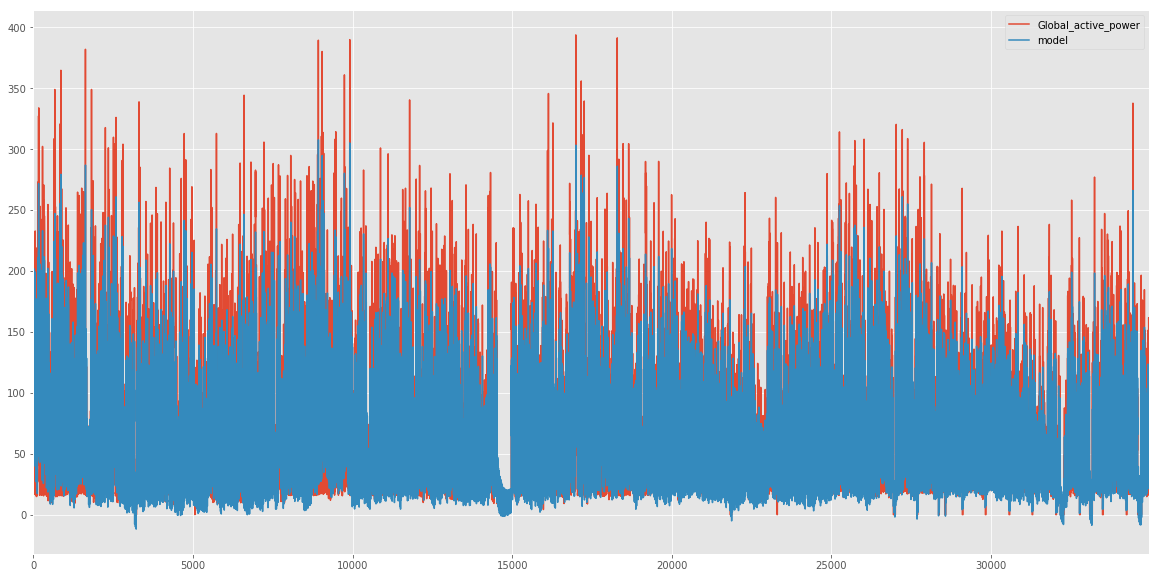

In [26]:
pred_all = results.predict(start=0, end=34950)

ax = y_sales.plot(figsize=(20, 10))

pd.DataFrame(pred_all + trend_seas, columns=['model']).plot(ax=ax)

plt.legend()
plt.show()

In [27]:
pred_step_out = results.predict(start=0, end=34958)
len(pred_step_out)

34959

In [28]:
    #Time scale
    predic2 = range(len(pred_step_out))

    #Applying the Fourier series to the time scale
    predic_annual_cos1 = list(map(lambda x: math.cos(2*math.pi*x/365), predic2))
    predic_annual_sin1 = list(map(lambda x: math.sin(2*math.pi*x/365), predic2))

    predic_month_cos1 = list(map(lambda x: math.cos(2*math.pi*x/30), predic2))
    predic_month_sin1 = list(map(lambda x: math.sin(2*math.pi*x/30), predic2))

    predic_week_cos1 = list(map(lambda x: math.cos(2*math.pi*x/7), predic2))
    predic_week_sin1 = list(map(lambda x: math.sin(2*math.pi*x/7), predic2))

    #assembling the regressors
    reg1 = pd.DataFrame(list(zip(predic2, predic_annual_cos1, predic_annual_sin1, predic_month_cos1, predic_month_sin1, predic_week_cos1, predic_week_sin1)), 
                   columns =['predic2', 'predic_annual_cos1', 'predic_annual_sin1', 'predic_month_cos1', 'predic_month_sin1', 'predic_week_cos1', 'predic_week_sin1']) 

    #Model
    model2 = LinearRegression().fit(reg, y_sales)
    
    trend1 = model2.intercept_ + model2.coef_[0][0]*np.array(predic2)
    seas_annual1 = model.coef_[0][1]*np.array(predic_annual_cos1) + model.coef_[0][2]*np.array(predic_annual_sin1)
    seas_month1 = model.coef_[0][3]*np.array(predic_month_cos1) + model.coef_[0][4]*np.array(predic_month_sin1)
    seas_week1 = model.coef_[0][5]*np.array(predic_week_cos1) + model.coef_[0][6]*np.array(predic_week_sin1)

    testerino = trend1 + seas_annual1 + seas_month1 + seas_week1
    

In [29]:
pred_step_out.index = pred_step_out.index-1

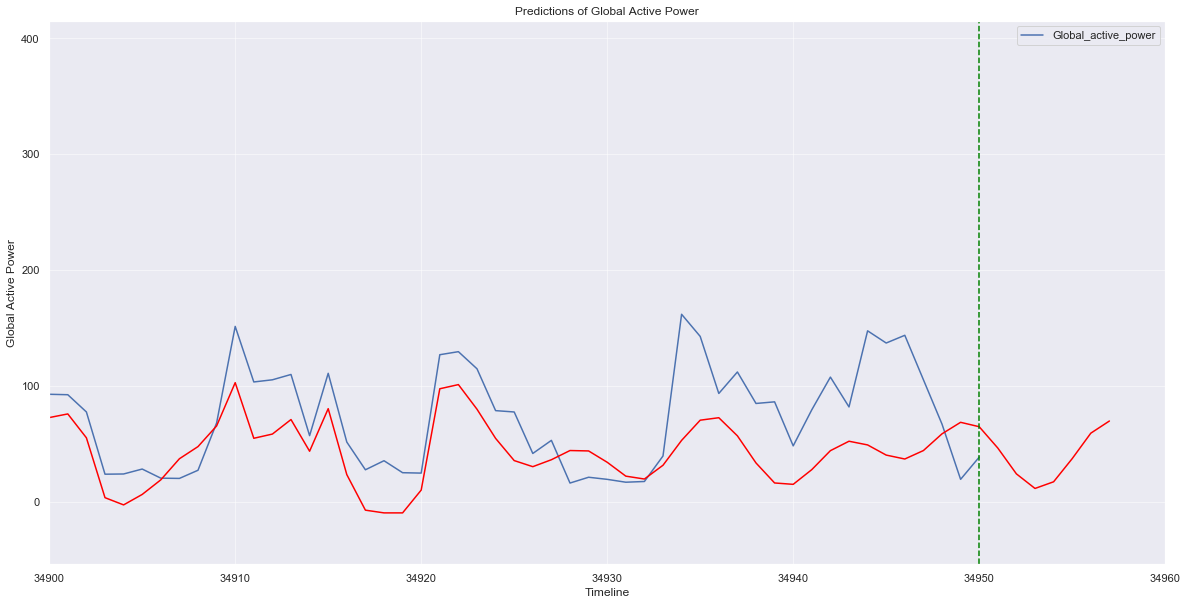

In [30]:
# newtrend = get_trend(pred_step_out)
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=y_sales, color="green").set_xlim(34900, 34960)
sns.lineplot(data=pred_step_out+testerino, color="red").set_xlim(34900, 34960)
# sns.lineplot(data=testerino).set_xlim(34900, 35000)

plt.title('Predictions of Global Active Power')
plt.xlabel('Timeline')
plt.ylabel('Global Active Power')
plt.grid(which='major', color="#ffffff", alpha=.5)
plt.axvline(x=y_sales.index[-1], color="green", linestyle="--")